In [152]:
from utils.data_acquisition import get_players, get_matches, get_players_perfomance, get_next_match

## Generating player list ranked by position

In [153]:
players = get_players()

In [154]:
positions = players['position'].unique()

In [155]:
players_ranked = players.copy() 
players_ranked['rank'] = None

for position in positions:
    rank = players_ranked[players_ranked['position'] == position].id.rank(method='min')
    rank = rank - 1
    players_ranked.iloc[rank.index,-1] = rank

columns_sorted = ["rank", "nickname", "id", "position", "price", "team", "status"]
players_ranked = players_ranked[columns_sorted].drop_duplicates().sort_values('rank', ignore_index=True)

In [156]:
players_ranked.head(10)

,rank,nickname,id,position,price,team,status
0,0.0,Rafinha,38144,lat,7.00,SAO,Nulo
1,0.0,Fábio,37656,gol,8.09,FLU,Provável
2,0.0,Hulk,39148,ata,16.16,CAM,Provável
3,0.0,Thiago Silva,37715,zag,10.00,FLU,Nulo
4,0.0,Renato Augusto,38398,mei,5.52,FLU,Nulo
5,0.0,Mano Menezes,37281,tec,8.86,FLU,Provável
6,1.0,Vagner Mancini,39850,tec,7.01,ACG,Provável
7,1.0,Thiago Heleno,38394,zag,5.06,CAP,Provável
8,1.0,Marcelo,38402,lat,9.64,FLU,Dúvida
9,1.0,Cássio,42234,gol,11.40,CRU,Nulo


## Matches

In [157]:
matches = get_matches()

In [158]:
matches["home_score_norm"] = matches["home_score"]/matches["home_score"].max()
matches["away_score_norm"] = matches["away_score"]/matches["away_score"].max()

In [159]:
matches.shape

(140, 8)

In [160]:
matches.head()

,date,home_team,away_team,home_score,away_score,round,home_score_norm,away_score_norm
0,2024-04-13 18:30:00,INT,BAH,2.0,1.0,1,0.4,0.166667
1,2024-04-13 18:30:00,CRI,JUV,1.0,1.0,1,0.2,0.166667
2,2024-04-13 21:00:00,FLU,BGT,2.0,2.0,1,0.4,0.333333
3,2024-04-13 21:00:00,SAO,FOR,1.0,2.0,1,0.2,0.333333
4,2024-04-14 16:00:00,VAS,GRE,2.0,1.0,1,0.4,0.166667


In [161]:
matches.iloc[-1]

date               2024-07-04 20:00:00
home_team                          COR
away_team                          VIT
home_score                         3.0
away_score                         2.0
round                               14
home_score_norm                    0.6
away_score_norm               0.333333
Name: 139, dtype: object

Remark: RS teams didn't player last rounds

In [162]:
matches = matches.dropna().reset_index()

In [163]:
matches.shape

(135, 9)

### Players performance

In [164]:
players_performance = get_players_perfomance()

In [165]:
players_performance = players_performance.drop(
    ["price", "nickname", "position", "team"], axis=1)

In [166]:
players_performance.head()

,id,points,round
0,100079,2.6,1
1,100084,1.4,1
2,100085,5.0,1
3,100652,1.3,1
4,100846,-1.5,1


Joining the above table with the players table, which contains the ranks

In [167]:
players_performance = players_performance.set_index("id").join(players_ranked.set_index("id"))

In [168]:
players_performance.head()

,points,round,rank,nickname,position,price,team,status
id,,,,,,,,
100079,2.6,1,94.0,Zaracho,mei,7.55,CAM,Nulo
100084,1.4,1,95.0,Igor Gomes,mei,5.22,CAM,Provável
100085,5.0,1,96.0,Pedro Augusto,mei,3.72,FOR,Provável
100652,1.3,1,70.0,Yuri Alberto,ata,7.05,COR,Provável
100846,-1.5,1,49.0,Lucas Esteves,lat,3.35,VIT,Provável


**Remark**: The price column here can lead to confusion. This price was get from the market database. So, it is the current price of the player in the market.
For this reason, I will rename the column: 

In [169]:
players_performance = players_performance.rename(columns={"price": "current_price"})

In [170]:
players_performance.columns

Index(['points', 'round', 'rank', 'nickname', 'position', 'current_price',
       'team', 'status'],
      dtype='object')

In [171]:
players_performance.shape

(4393, 8)

Removing player that are not available in the market

In [172]:
players_performance.drop(
    players_performance[players_performance['rank'].isnull()].index,
    inplace=True)

players_performance['rank'] = players_performance['rank'].astype(int)

In [173]:
players_performance.head()

,points,round,rank,nickname,position,current_price,team,status
id,,,,,,,,
100079,2.6,1,94,Zaracho,mei,7.55,CAM,Nulo
100084,1.4,1,95,Igor Gomes,mei,5.22,CAM,Provável
100085,5.0,1,96,Pedro Augusto,mei,3.72,FOR,Provável
100652,1.3,1,70,Yuri Alberto,ata,7.05,COR,Provável
100846,-1.5,1,49,Lucas Esteves,lat,3.35,VIT,Provável


In [174]:
players_performance.shape

(4271, 8)

## Transition matrix M between the states
Until here, it is not clear for me yet what the states in this matrix means

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from typing import Literal, Callable, Tuple
from numpy._typing import NDArray, ArrayLike

In [176]:
def normalize_transition_matrix(m: NDArray) -> NDArray:
    """."""
    M_norm = m.copy()
    M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.
    M_norm = np.nan_to_num(M_norm, nan=1/M_norm.shape[0])  # Replacing no info rows with equally distributed probability
    return M_norm

In [177]:
def forward(home_goals: int, away_goals: int) -> Tuple[int, int]:
    return home_goals, away_goals

def defender(home_goals: int, away_goals: int):
    home_extra_score, away_extra_score = 1, 1
    if away_goals:
        home_extra_score =- 1
    if home_goals:
        away_extra_score = -1
    return home_extra_score, away_extra_score

def midfilder(home_goals: int, away_goals: int) -> Tuple[int, int]:
    forward_h, forward_a = forward(home_goals, away_goals)
    defender_h, defender_a = defender(home_goals, away_goals)
    return forward_h + defender_h, forward_a + defender_a

def manager(*args) -> Tuple[int, int]:
    return 0,0

In [178]:
def generate_m_matrix(
        position: Literal["ata", "mei", "zag", "tec"], 
        extra_function: Callable[[int, int], Tuple[int, int]]
) -> NDArray:
    """."""
    players_performance_position = players_performance[
        players_performance["position"] == position
        ].copy()

    n_players = len(players_ranked[players_ranked["position"] == position])
    M = np.zeros([n_players, n_players])

    # The match are labeled from 0 to len(matches)
    for match in range(len(matches)):
        # Selecting all players that played in the round where the match ocurred
        df_round = players_performance_position[
            players_performance_position["round"] == matches["round"][match]
        ]
        # Selecting the players that played in the given match
        players_home = df_round[df_round["team"] == matches["home_team"][match]]
        players_away = df_round[df_round["team"] == matches["away_team"][match]]

        for p_home in range(len(players_home)):
            for p_away in range(len(players_away)):
                score_home, score_away = 0,0
            
                points_p_home = players_home["points"].iloc[p_home]
                points_p_away = players_away["points"].iloc[p_away]

                sum = points_p_home + points_p_away
                if sum != 0:
                    score_home = points_p_home/sum
                    score_away = points_p_away/sum
                
                # Selecting the coordinates of each player in the matrix
                p1 = players_home["rank"].iloc[p_home]
                p2 = players_away["rank"].iloc[p_away]

                home_extra_score, away_extra_score = extra_function(
                    matches['home_score_norm'][match],
                    matches['away_score_norm'][match]
                )
                home_extra_score, away_extra_score = 0,0

                M[p1,p1] = M[p1,p1] + home_extra_score + score_home
                M[p1,p2] = M[p1,p2] + away_extra_score + score_away
                M[p2,p1] = M[p2,p1] + home_extra_score + score_home
                M[p2,p2] = M[p2,p2] + away_extra_score + score_away
    
    # return normalize_transition_matrix(M)
    return M


In [179]:
def stacionary_distribution(m_norm: NDArray) -> ArrayLike:
    """."""
    tolerances = [1e-10, 1e-4, 1e-3, 1e-2]
    evals, evecs = np.linalg.eig(m_norm.T)
    
    for tol in tolerances:
        try: # TODO: Change this to a size validation
            # evec1 = evecs[:,np.isclose(evals, 1, rtol=0, atol=tol)] # Increase the tolerance a little
            evec1 = evecs[:,np.isclose(evals, 1, rtol=0, atol=tol)] # Increase the tolerance a little
            evec1 = evec1[:,0]
        except:
            print(f"tolerance: {tol} didn't work")
            continue
        stationary = evec1 / evec1.sum()
        stationary = stationary.real
        return stationary, evals, evecs

In [180]:
out_data = {
    "gol": {"func": defender},
    "zag": {"func": defender},
    "lat": {"func": defender},
    "mei": {"func": midfilder},
    "ata": {"func": forward},
    "tec": {"func": manager}
}

In [181]:
for position, content in out_data.items():
    content['M'] = generate_m_matrix(position, content["func"])
    content['M_norm'] = normalize_transition_matrix(content['M'])
    content["st_dist"], *_ = stacionary_distribution(content['M_norm'])

/tmp/ipykernel_12074/3863926212.py:4: RuntimeWarning: invalid value encountered in divide
  M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.


Transiction matrix plot

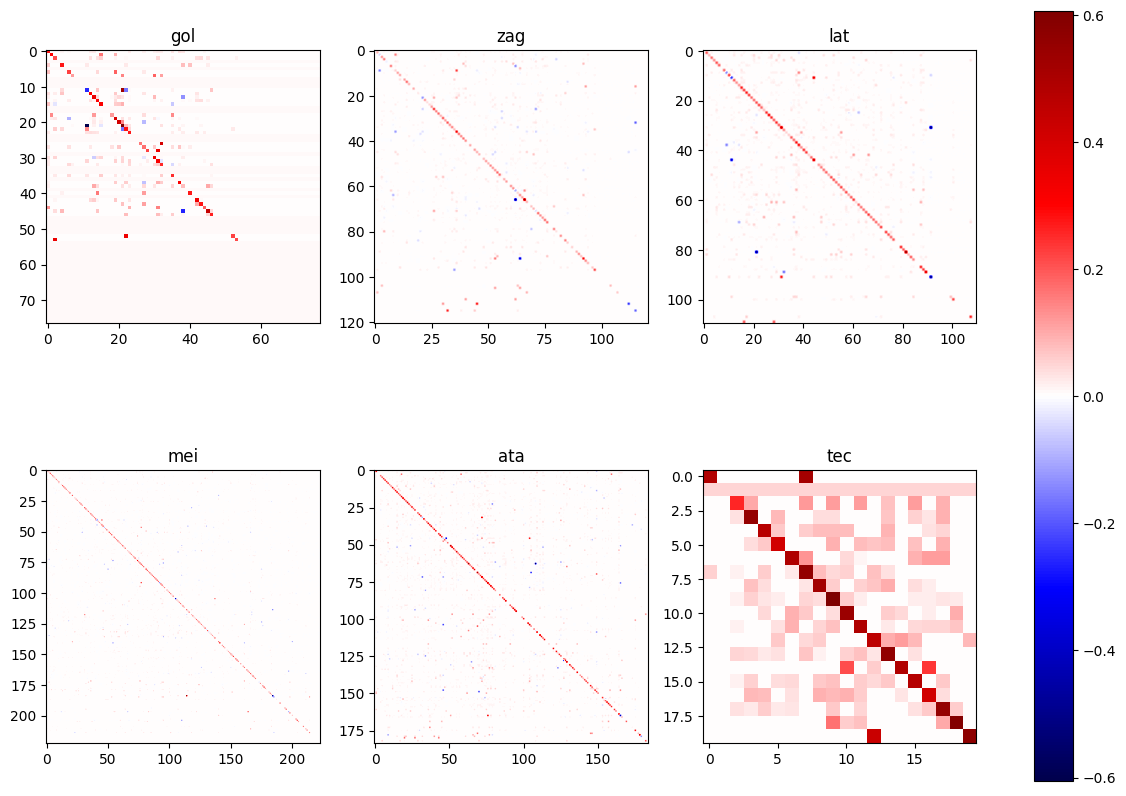

In [182]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].imshow(out_data[key]["M_norm"], cmap='seismic', norm=TwoSlopeNorm(0))
    axesli[i].set_title(key)

fig.colorbar(im, ax=axes.ravel())


Stationary Distribution plot 

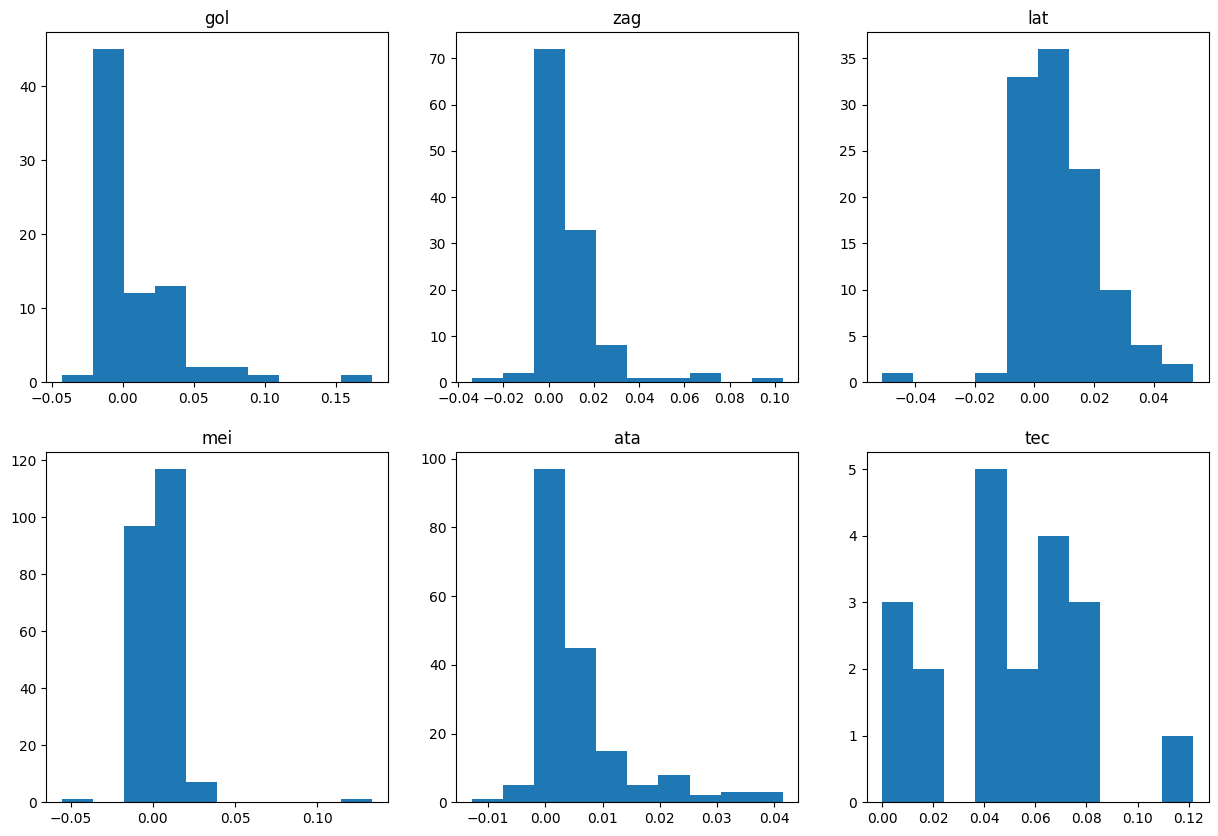

In [183]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].hist(out_data[key]["st_dist"])
    axesli[i].set_title(key)

### Overperfomance players for each position

In [184]:
position = 'gol'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
1,0.0,Fábio,37656,gol,8.09,FLU,Provável
16,2.0,Walter,51413,gol,4.84,CUI,Provável
76,12.0,Marchesín,70332,gol,5.78,GRE,Nulo
81,13.0,Gabriel,70449,gol,4.24,JUV,Provável
85,14.0,Weverton,71631,gol,10.34,PAL,Provável


In [185]:
position = 'zag'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)]

,rank,nickname,id,position,price,team,status
22,3.0,Titi,50353,zag,4.55,FOR,Nulo
27,4.0,David Luiz,52827,zag,6.19,FLA,Provável
84,14.0,Mercado,72951,zag,5.07,INT,Nulo
153,26.0,Léo Pereira,83528,zag,6.08,FLA,Nulo
170,30.0,Rodrigo,86684,zag,5.89,CRI,Provável
178,31.0,Pedro Henrique,87225,zag,5.67,BGT,Provável
191,34.0,Alan Empereur,88033,zag,2.80,CUI,Provável
203,36.0,Fabrício Bruno,90768,zag,5.31,FLA,Provável
205,37.0,Zé Marcos,90943,zag,3.46,JUV,Provável
224,40.0,Arboleda,91573,zag,7.41,SAO,Provável


In [186]:
position = 'lat'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > 0)].head()

,rank,nickname,id,position,price,team,status
0,0.0,Rafinha,38144,lat,7.00,SAO,Nulo
8,1.0,Marcelo,38402,lat,9.64,FLU,Dúvida
12,2.0,Mariano,38877,lat,4.18,CAM,Provável
20,3.0,Fagner,42500,lat,6.97,COR,Contundido
25,4.0,Cicinho,61106,lat,4.42,BAH,Nulo


In [187]:
position = 'mei'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
11,1.0,Nenê,38913,mei,4.44,JUV,Nulo
18,3.0,Everton Ribeiro,51772,mei,9.48,BAH,Provável
83,13.0,Nikão,69705,mei,8.81,CAP,Contundido
93,15.0,Bruno Henrique,70944,mei,6.34,INT,Provável
128,21.0,Fernandinho,72775,mei,8.06,CAP,Provável


In [188]:
position = 'ata'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
10,1.0,Osvaldo,42222,ata,4.29,VIT,Contundido
56,9.0,Pablo,69138,ata,5.39,CAP,Dúvida
90,15.0,Everaldo,78117,ata,7.76,BAH,Provável
118,19.0,Luciano,80287,ata,12.43,SAO,Provável
134,22.0,Luiz Araújo,82627,ata,9.25,FLA,Provável


In [189]:
position = 'tec'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
21,3.0,Tite,45125,tec,11.05,FLA,Provável
29,4.0,Cláudio Tencati,78450,tec,6.82,CRI,Provável
31,5.0,Roger Machado,79437,tec,6.68,JUV,Provável
37,6.0,Petit,89141,tec,6.13,CUI,Provável
42,7.0,Eduardo Coudet,94853,tec,9.01,INT,Provável


## Using linear programming to build the team

Adding probabilities in players on the market data

In [190]:
df_players_anl = players_ranked.copy()
df_players_anl['rank'] = df_players_anl['rank'].astype(int)
df_players_anl['prob'] = 0.00

In [191]:
def get_prob(df):
    position = df['position']
    rank = df['rank']
    return out_data.get(position)["st_dist"][int(rank)]

In [192]:
df_players_anl['prob'] = df_players_anl.apply(get_prob, axis=1)

In [193]:
df_players_anl.sort_values('prob', ascending=False).head()

,rank,nickname,id,position,price,team,status,prob
127,21,Marcos Felipe,85004,gol,7.45,BAH,Provável,0.175793
390,74,Raphael Veiga,94509,mei,12.62,PAL,Provável,0.133394
57,9,Rogério Ceni,97341,tec,10.05,BAH,Provável,0.121751
115,19,João Ricardo,81881,gol,8.43,FOR,Provável,0.105128
153,26,Léo Pereira,83528,zag,6.08,FLA,Nulo,0.103524


Lets remove probs that aren't between -1 and 1.

In [194]:
df_players_anl = df_players_anl[(df_players_anl['prob'] > -1) & (df_players_anl['prob'] < 1)]

In [195]:
df_players_anl['nickname'] = df_players_anl['nickname'].str.replace(" ", "_")
df_players_likely = df_players_anl[df_players_anl.status == "Provável"]

### Giving extra probability points for the players that will play at home.

I found this [study](https://www.scielo.br/j/rbcdh/a/wc9c38CkYs5NZJYSF6SpNJR/?format=pdf&lang=pt) who says that teams in brazillian championship has 25% more chance to win when playing at home;


In [196]:
next_matches = get_next_match()

In [197]:
home_team = next_matches["home_team"].values

In [198]:
home_team

array(['FLA', 'SAO', 'CRU', 'FOR', 'JUV', 'INT', 'VIT', 'PAL', 'ACG',
       'BOT'], dtype=object)

In [199]:
df_players_likely_bonus = df_players_likely.copy()

In [200]:
df_players_likely_bonus.loc[df_players_likely_bonus.team.isin(home_team), 'prob'] *= 1.25

In [201]:
df_players_likely_bonus.head()

,rank,nickname,id,position,price,team,status,prob
1,0,Fábio,37656,gol,8.09,FLU,Provável,0.041775
2,0,Hulk,39148,ata,16.16,CAM,Provável,0.008045
5,0,Mano_Menezes,37281,tec,8.86,FLU,Provável,0.008173
6,1,Vagner_Mancini,39850,tec,7.01,ACG,Provável,-0.000000
7,1,Thiago_Heleno,38394,zag,5.06,CAP,Provável,0.009016


### Optimization

In [202]:
from pulp import LpMaximize, LpProblem, lpSum, LpVariable
from itertools import product as  cartersian_product
import pandas as pd

In [203]:
# Team and money constraints
team = {
    'ata': 3,
    'mei': 3,
    'lat': 2,
    'zag': 2,
    'gol':1,
    'tec':1
}

money = 108.37

In [204]:
# Selecting the dataframe to use in the optimization
df = df_players_likely_bonus.copy()

In [205]:
df.set_index("id", inplace=True)
df.head()

,rank,nickname,position,price,team,status,prob
id,,,,,,,
37656,0,Fábio,gol,8.09,FLU,Provável,0.041775
39148,0,Hulk,ata,16.16,CAM,Provável,0.008045
37281,0,Mano_Menezes,tec,8.86,FLU,Provável,0.008173
39850,1,Vagner_Mancini,tec,7.01,ACG,Provável,-0.000000
38394,1,Thiago_Heleno,zag,5.06,CAP,Provável,0.009016


In [206]:
sorted = df.sort_values(by=['prob'], axis=0, ascending=False)
sorted[sorted.position == "ata"]

,rank,nickname,position,price,team,status,prob
id,,,,,,,
112886,111,Lucas_Barbosa,ata,9.37,JUV,Provável,0.050526
82627,22,Luiz_Araújo,ata,9.25,FLA,Provável,0.047238
94583,55,Pedro,ata,13.57,FLA,Provável,0.042409
117909,129,Wesley,ata,6.73,COR,Provável,0.041530
93478,52,Wanderson,ata,5.18,INT,Provável,0.030575
128915,164,Estêvão,ata,7.86,PAL,Provável,0.030323
90285,38,Bruno_Henrique,ata,10.97,FLA,Provável,0.028139
80287,19,Luciano,ata,12.43,SAO,Provável,0.026677
101960,76,Vitinho,ata,8.70,BGT,Provável,0.025418


In [207]:
all_conflicts = []
# Computing all combinations of players that will  play against
for _, row in next_matches.iterrows(): # We just have 9 lines, it is not too bad use iterrows here
    home_team, away_team = row['home_team'], row['away_team']
    players_home = df[df['team'] == home_team].index.values
    players_away = df[df['team'] == away_team].index.values
    all_conflicts += list(cartersian_product(players_home, players_away))

In [208]:
len(all_conflicts)

1187

In [209]:
z = df['prob'].to_dict()
c = df['price'].to_dict()

dummies_position = pd.get_dummies(df.position)
dummies_position = dummies_position.to_dict()
prob = LpProblem("Players CHoice", LpMaximize)
y = LpVariable.dicts("player_id", df.index , 0,1, cat='Binary')
prob += lpSum([z[i] * y[i] for i in y])

/home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [210]:
prob += lpSum([c[i] * y[i] for i in y]) <= money, "money_limit"
prob += lpSum([dummies_position['ata'][i] * y[i] for i in y]) == team['ata'], "Quantidade Atacantes"
prob += lpSum([dummies_position['lat'][i] * y[i] for i in y]) == team['lat'], "Quantidade Laterais"
prob += lpSum([dummies_position['mei'][i] * y[i] for i in y]) == team['mei'], "Quantidade Meio"
prob += lpSum([dummies_position['zag'][i] * y[i] for i in y]) == team['zag'], "Quantidade Zagueiros"
prob += lpSum([dummies_position['gol'][i] * y[i] for i in y]) == team['gol'], "Quantidade Gol"
prob += lpSum([dummies_position['tec'][i] * y[i] for i in y]) == team['tec'], "Quantidade Tecnico"

# Add the conflicts rule
for i, j in all_conflicts:
    prob += y[i] + y[j] <= 1

In [211]:
money

108.37

In [212]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2bdd9477c29c42e396966cd8c13e046c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2bdd9477c29c42e396966cd8c13e046c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1199 COLUMNS
At line 4663 RHS
At line 5858 BOUNDS
At line 6077 ENDATA
Problem MODEL has 1194 rows, 218 columns and 2810 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.829564 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 subs

1

In [213]:
escalados = []
for v in prob.variables():
    if v.varValue == 1:
        atleta = v.name.replace('player_id_','')
        escalados.append(int(atleta))
        print(atleta, "=", v.varValue)

110506 = 1.0
110668 = 1.0
112886 = 1.0
117632 = 1.0
81881 = 1.0
82627 = 1.0
86684 = 1.0
89256 = 1.0
94509 = 1.0
94583 = 1.0
95466 = 1.0
98280 = 1.0


In [214]:
my_team = df.loc[escalados]

In [215]:
my_team

,rank,nickname,position,price,team,status,prob
id,,,,,,,
110506,13,Abel_Ferreira,tec,11.69,PAL,Provável,0.102184
110668,79,Esquivel,lat,8.56,CAP,Provável,0.042522
112886,111,Lucas_Barbosa,ata,9.37,JUV,Provável,0.050526
117632,168,Garro,mei,10.09,COR,Provável,0.030068
81881,19,João_Ricardo,gol,8.43,FOR,Provável,0.131409
82627,22,Luiz_Araújo,ata,9.25,FLA,Provável,0.047238
86684,30,Rodrigo,zag,5.89,CRI,Provável,0.070586
89256,55,Gerson,mei,6.27,FLA,Provável,0.026460
94509,74,Raphael_Veiga,mei,12.62,PAL,Provável,0.166742


In [216]:
my_team['price'].sum()

106.85000000000001

In [217]:
# Captain
my_team[my_team['position'].isin(["ata", "mei"])].sort_values('prob', axis=0, ascending=False)

,rank,nickname,position,price,team,status,prob
id,,,,,,,
94509,74,Raphael_Veiga,mei,12.62,PAL,Provável,0.166742
112886,111,Lucas_Barbosa,ata,9.37,JUV,Provável,0.050526
82627,22,Luiz_Araújo,ata,9.25,FLA,Provável,0.047238
94583,55,Pedro,ata,13.57,FLA,Provável,0.042409
117632,168,Garro,mei,10.09,COR,Provável,0.030068
89256,55,Gerson,mei,6.27,FLA,Provável,0.026460


TODO: 
- ~~Adicionar bonus para o caso do próximo jogo ser em casa;~~
- Adicionar bonus para quem joga contra os últimos da tabela; ou a diferença entre as posições(?)
- ~~Adicionar restrição para que os jogadores escalados não se enfrentem na rodada;~~
- Adicionar minimização para escolher os melhores reservas;
- Adicionar possibilidade de outras escalações;
- ~~Adicionar método para a escolha do capitão.~~



## Model Results

In [218]:
results = pd.read_csv("results/2024.csv")

In [219]:
results.columns

Index(['Rodada', 'Score', 'Players Mean', 'Money', 'Aditional Info'], dtype='object')

<Axes: title={'center': 'Model Results'}, xlabel='Rodada'>

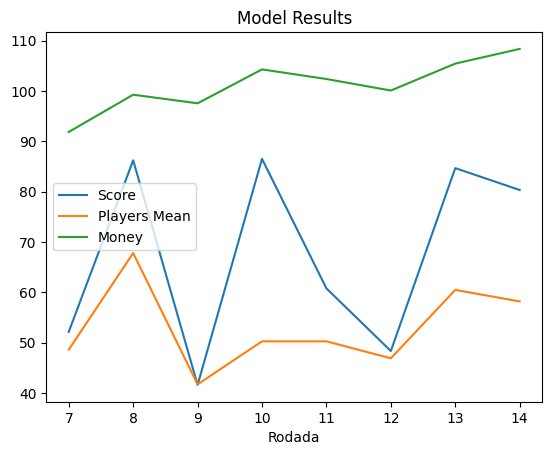

In [220]:
results.plot(x='Rodada', y=['Score', 'Players Mean', "Money"], title='Model Results')